Author: Alexis Laignelet \\
Date: 8th June 2020

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy.stats as stats
import pandas as pd
from abc import ABC, abstractmethod 
from sklearn.tree import DecisionTreeRegressor

# Bandits

In [0]:
class Bandit:
  def __init__(self, k, mean_distribution, reward_distribution, policy):
    self.k = k
    self.arm_means = mean_distribution().rvs(k)
    self.arm_reward_distributions = [reward_distribution(mean) for mean in self.arm_means]
    self.arm_trial_counts = np.zeros(k)
    self.policy = policy

  def get_reward(self, chosen_arm):
    reward = self.arm_reward_distributions[chosen_arm].rvs()
    return reward

  def run_experiment(self):
    chosen_arm = self.policy.choose_arm()
    reward = self.get_reward(chosen_arm)
    self.policy.update_policy(chosen_arm, reward)
    return reward

In [0]:
class ContextualBandit:
  def __init__(self, mean_distribution, reward_distribution, policy, context):
    self.context = context
    self.time = 0
    self.reward_distribution = reward_distribution
    self.arm_means = mean_distribution(self.context(self.time))
    self.arm_reward_distributions = [reward_distribution(mean) for mean in self.arm_means]
    self.policy = policy

  def get_reward(self, chosen_arm):
    reward = self.arm_reward_distributions[chosen_arm].rvs()
    return reward

  def update_reward_distribution(self, context):
    self.arm_means = mean_distribution(self.context(self.time))
    self.arm_reward_distributions = [self.reward_distribution(mean) for mean in self.arm_means]

  def update_time(self):
    self.time += 1

  def run_experiment(self):
    context = self.context(self.time)
    self.update_reward_distribution(context)
    self.policy.make_predictions(context)
    chosen_arm = self.policy.choose_arm()
    reward = self.get_reward(chosen_arm)
    self.policy.update_dataset(chosen_arm, self.time, context, reward)
    self.policy.retrain_model(chosen_arm)
    self.update_time()

# Policies

In [0]:
class Policy(ABC):
  @abstractmethod
  def choose_arm(self):
    pass

  @abstractmethod
  def update_policy(self, chosen_arm, reward):
    pass

In [0]:
class GreedyPolicy(Policy):
  def __init__(self, epsilon, k):
    self.k = k
    self.epsilon = epsilon
    self.arm_estimated_means = np.zeros(self.k)
    self.arm_trial_counts = np.zeros(self.k)

  def choose_arm(self): 
    if self.epsilon > np.random.uniform(0, 1): 
        chosen_arm = np.random.randint(self.k)
    else:
        chosen_arm = np.argmax(self.arm_estimated_means)
    return chosen_arm   

  def update_policy(self, chosen_arm, reward):
    self.arm_trial_counts[chosen_arm] += 1 
    alpha = 1./self.arm_trial_counts[chosen_arm]
    self.arm_estimated_means[chosen_arm] += alpha * (reward - self.arm_estimated_means[chosen_arm])

In [0]:
class UBCPolicy(Policy):
  def __init__(self, k):
    self.k = k
    self.arm_radiuses = np.zeros(k)
    self.arm_estimated_means = np.zeros(self.k)
    self.arm_trial_counts = np.zeros(self.k)

  def choose_arm(self):
    return np.argmax(self.arm_estimated_means + self.arm_radiuses)

  def update_policy(self, chosen_arm, reward):
    self.arm_trial_counts[chosen_arm] += 1 
    self.arm_radiuses = np.sqrt(2 * np.log(1 + self.arm_trial_counts.sum()) / (1 + self.arm_trial_counts))
    alpha = 1./self.arm_trial_counts[chosen_arm]
    self.arm_estimated_means[chosen_arm] += alpha * (reward - self.arm_estimated_means[chosen_arm])

In [0]:
class ThompsonPolicy(Policy):
  def __init__(self, k):
    self.k = k
    self.arm_trial_counts = np.zeros(self.k)
    self.arm_success_counts = np.zeros(self.k) 
    self.arm_prior_distributions = [stats.beta(a=1, b=1) for i in range(self.k)]
  
  def choose_arm(self):
    theta_samples = np.array([distribution.rvs(1).item() for distribution in self.arm_prior_distributions])
    return np.argmax(theta_samples)

  def update_policy(self, chosen_arm, reward):
    self.arm_trial_counts[chosen_arm] += 1
    self.arm_success_counts[chosen_arm] += reward
    posterior_distributions = [stats.beta(a=1+success_count, b=1+trial_count-success_count)
                               for trial_count, success_count in zip(self.arm_trial_counts, self.arm_success_counts)]
    self.arm_prior_distributions = posterior_distributions

In [0]:
class ContextualGreedyPolicy:
  def __init__(self, epsilon, k=2):
    self.k = k
    self.epsilon = epsilon
    self.arm_estimated_means = np.zeros(self.k)
    self.arm_trial_counts = np.zeros(self.k)
    self.learning_algorithm = self.initialise_models() 
    self.trained_models = [None] * 2
    self.datasets = [pd.DataFrame(columns=['time', 'context', 'reward'])] * 2

  def initialise_models(self):
    list_of_models = []
    for i in range(self.k):
      model = DecisionTreeRegressor()
      list_of_models.append(model)
    return list_of_models

  def choose_arm(self): 
    if self.epsilon > np.random.uniform(0, 1): 
        chosen_arm = np.random.randint(self.k)
    else:
        chosen_arm = np.argmax(self.arm_estimated_means)
    return chosen_arm

  def make_predictions(self, context):
    for i in range(self.k):
      if self.trained_models[i] != None:
        self.arm_estimated_means[i] = self.trained_models[i].predict(context.reshape(-1, 1))
  
  def update_dataset(self, chosen_arm, time, context, reward):
    row = [time, context, reward]
    df = self.datasets[chosen_arm]
    new_data = pd.DataFrame([row], columns=['time','context','reward'])
    self.datasets[chosen_arm] = pd.concat([df,new_data])

  def retrain_model(self, chosen_arm):
    X = self.datasets[chosen_arm]['context']
    y = self.datasets[chosen_arm]['reward']
    self.trained_models[chosen_arm] = self.learning_algorithm[chosen_arm].fit(X.values.reshape(-1, 1), y)

# Example 1 - Stochastic bandits

Let k arms with rewards following a Gaussian distribution $\mathcal{N}(\mu_i, 1)$. For simplicity the means $\mu_i$ are generated from a uniform distribution $\mathcal{U}[0, 1]$.

Two policies are implemented:


*   $\epsilon$-greedy,
*   Upper Confidence Bound.


The estimated mean is computed this way:
\begin{align*}
  \mathbb{E}[\mu_a] \leftarrow  \mathbb{E}[\mu_a] + \alpha \left(R_{a, t} - \mathbb{E}[\mu_a] \right)
\end{align*}

Usually $\alpha = \frac{1}{T_a}$ but you can 'forget' faster by taking higher values for $\alpha$. Eg $\alpha = 0.1$. 


In [0]:
def multi_experiments(bandit, experiences):
  max_mean = max(bandit.arm_means)
  rewards = np.zeros(experiences) 
  regrets = np.zeros(experiences+1)
  
  for it in range(experiences):
    reward = bandit.run_experiment()
    rewards[it] = reward
    regrets[it+1] = regrets[it] + max_mean - reward

  return rewards, regrets[1:]

In [0]:
def average_results(k, mean_distribution, reward_distribution, experiences, n_average, epsilon=None):
  average_rewards = np.zeros(experiences)
  average_regrets = np.zeros(experiences)

  for i in tqdm(range(n_average)):
    if epsilon != None:
      policy = GreedyPolicy(epsilon=epsilon, k=k)
    else:
      policy = UBCPolicy(k)
    bandit = Bandit(k=k, mean_distribution=mean_distribution, reward_distribution=reward_distribution, policy=policy)
    new_rewards, new_regrets = multi_experiments(bandit, experiences)
    average_rewards += new_rewards
    average_regrets += new_regrets 

  average_rewards /= n_average 
  average_regrets /= n_average
  return average_rewards, average_regrets

In [0]:
def normal_reward(mean):
  return stats.norm(loc=mean, scale=1.)

def normal_mean():
  return stats.norm(loc=0, scale=1.)

In [0]:
k = 10
epsilon = 0.01
mean_distribution = normal_mean
reward_distribution = normal_reward
experiences = 1000
n_average = 200

In [13]:
average_rewards_greedy, average_regrets_greedy = average_results(k, mean_distribution, reward_distribution, experiences, n_average, epsilon=epsilon)
average_rewards_ucb, average_regrets_ucb = average_results(k, mean_distribution, reward_distribution, experiences, n_average)

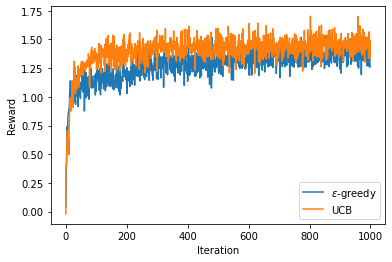

In [14]:
plt.plot(average_rewards_greedy, label='$\epsilon$-greedy')
plt.plot(average_rewards_ucb, label='UCB')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.legend();

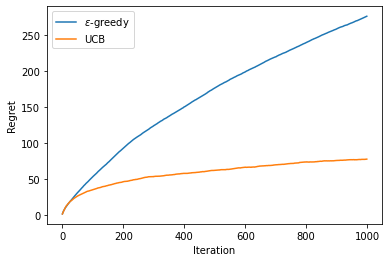

In [15]:
plt.plot(average_regrets_greedy, label='$\epsilon$-greedy')
plt.plot(average_regrets_ucb, label='UCB')
plt.xlabel('Iteration')
plt.ylabel('Regret')
plt.legend();

# Example 2 - Bernoulli bandits

In this setup, the likelihood $p(x | \theta)$ follows a Bernoulli. A natural choice for the prior is the Beta distribution since it is a conjugate prior with the Bernoulli distribution. In this context, the posterior is also a Beta distribution that evolves according to: if $x$ is a win, the posterior becomes $Beta(\alpha +1, \beta)$, and if it is a fail, it becomes $Beta(\alpha, \beta +1)$.


In [0]:
def plot_thompson_priors(policy, ax, experience):
  x = np.linspace(0.001, 0.999, 100)
  for arm_prior_distribution in policy.arm_prior_distributions:
      y = arm_prior_distribution.pdf(x)
      ax.plot(x, y)
      ax.fill_between(x, y, 0, alpha=0.2)
  ax.set_xlabel('x')
  ax.set_ylabel('Prior')
  ax.set_title('t = ' + str(experience))

In [0]:
def bernoulli_reward(mean):
  return stats.bernoulli(mean)

def uniform_mean():
  return stats.uniform(loc=0, scale=1.)

In [0]:
k = 3
mean_distribution = uniform_mean
reward_distribution = bernoulli_reward
experiences = 50
indexes = [int(ratio * (experiences-1)) for ratio in [0.25, 0.5, 0.75, 1.]]

In [0]:
policy = ThompsonPolicy(k)
bandit = Bandit(k=k, mean_distribution=mean_distribution, reward_distribution=reward_distribution, policy=policy)

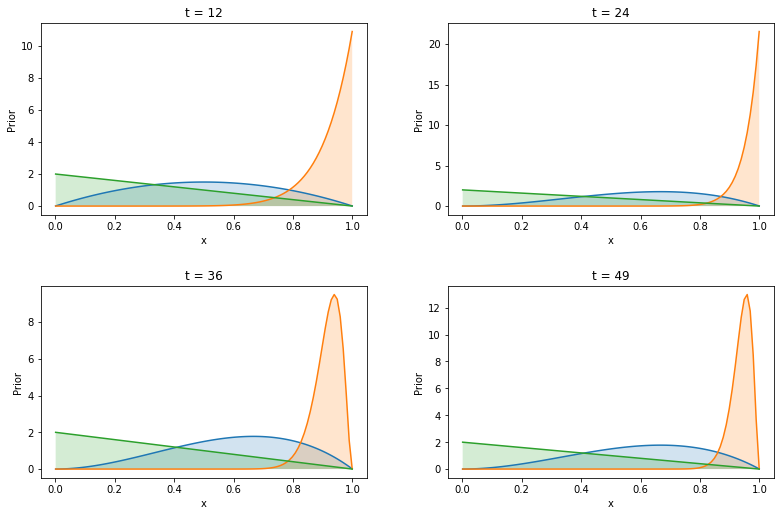

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(12,8))
axs = axs.flatten()
fig.tight_layout(pad=5.0)
for experience in range(experiences):
  bandit.run_experiment()
  if experience in indexes:
    policy = bandit.policy
    plot_thompson_priors(policy=policy, ax=axs[indexes.index(experience)], experience=experience)

# Example 3 - Contextual bandits

In this setup, the context influences the probabilities of the reward of each arm. We first define a mean per arm depending on the context, and then the reward which is a noisy version on the mean.

For convenience, the context is model by a unique variable $x$ which oscillate throught time, and we use decision tree as model to make predictions on the rewards.

In [0]:
def mean_distribution(context):
  return [1 if context >= 0 else 0, 1 if context < 0 else 0]

def normal_reward(mean):
  return stats.norm(loc=mean, scale=0.1)

def sine_context(time):
  return np.sin(0.1 * time)

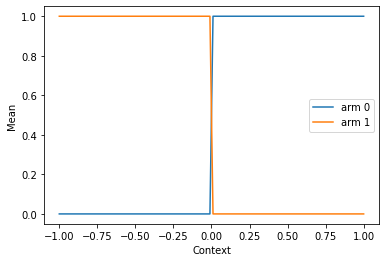

In [22]:
x = np.linspace(-1, 1, 100)
y = np.array([mean_distribution(values) for values in x])
plt.plot(x, y[:,0], label='arm 0')
plt.plot(x, y[:,1], label='arm 1')
plt.xlabel('Context')
plt.ylabel('Mean')
plt.legend();

In [0]:
epsilon = 0.1
mean_distribution = mean_distribution
reward_distribution = normal_reward
context = sine_context

In [0]:
policy = ContextualGreedyPolicy(epsilon=epsilon)
cbandit = ContextualBandit(mean_distribution=mean_distribution, reward_distribution=reward_distribution, policy=policy, context=context)

In [0]:
experiences = 150
for experience in range(experiences):
  cbandit.run_experiment()

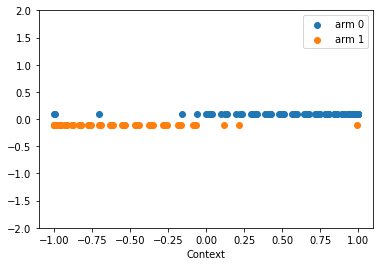

In [26]:
plt.scatter(policy.datasets[0]['context'], np.zeros_like(policy.datasets[0]['context']) + 0.1, label='arm 0')
plt.scatter(policy.datasets[1]['context'], np.zeros_like(policy.datasets[1]['context']) - 0.1, label='arm 1')
plt.ylim(-2, 2)
plt.xlabel('Context')
plt.legend();

In [0]:
dataset = pd.concat([policy.datasets[0], policy.datasets[1]])
dataset = dataset.sort_values(by='time')

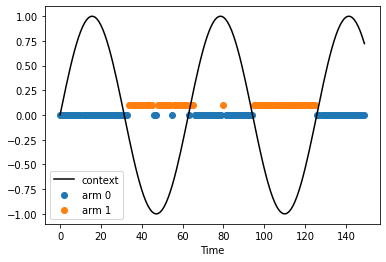

In [28]:
plt.scatter(policy.datasets[0]['time'], np.zeros_like(policy.datasets[0]['context']), label='arm 0')
plt.scatter(policy.datasets[1]['time'], np.zeros_like(policy.datasets[1]['context']) + 0.1, label='arm 1')
plt.plot(dataset['time'], dataset['context'], color='black', label='context')
plt.xlabel('Time')
plt.legend();